In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import COLLECTIONS as cln
from IPython.display import clear_output
import html5lib
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cnx = create_engine('postgresql://%s:%s@localhost:%s/%s' % (cln.username, 
                                                            cln.password, 
                                                            cln.port,
                                                            cln.db_name))

In [3]:
carrier = 'DL'
airport = 'JFK'

In [4]:
query = """SELECT * FROM 
                (SELECT * FROM ontimeperformance
                 JOIN weatherairportlinks ON weatherairportlinks."IATA" = ontimeperformance."Origin"
                 WHERE "Carrier" = '%s' AND "Origin" = '%s') AS sub
           JOIN weather ON weather."Date" = sub."FlightDate" AND
                           weather."StationID" = sub."StationID" """ % (carrier, airport)
query

'SELECT * FROM \n                (SELECT * FROM ontimeperformance\n                 JOIN weatherairportlinks ON weatherairportlinks."IATA" = ontimeperformance."Origin"\n                 WHERE "Carrier" = \'DL\' AND "Origin" = \'JFK\') AS sub\n           JOIN weather ON weather."Date" = sub."FlightDate" AND\n                           weather."StationID" = sub."StationID" '

In [5]:
df = pd.read_sql_query(query, cnx)

In [6]:
len(df)

2205426

In [7]:
len(pd.unique(df['PerformanceID']))

185672

In [8]:
len(df)

2205426

In [9]:
df[~df['WeatherDelay'].isnull()][['DepDelay', 'ArrDelay', 
                                  'CRSArrTime', 'ArrTime', 
                                  'WheelsOn', 'WeatherDelay', 
                                  'LateAircraftDelay', 'CarrierDelay', 
                                  'NASDelay', 'SecurityDelay']].sort_values('ArrDelay', 
                                                                            ascending=False).head()

,DepDelay,ArrDelay,CRSArrTime,ArrTime,WheelsOn,WeatherDelay,LateAircraftDelay,CarrierDelay,NASDelay,SecurityDelay
1266506,1150.0,1177.0,22:54:00,18:31:00,18:21:00,0.0,0.0,1150.0,27.0,0.0
1266236,1150.0,1177.0,22:54:00,18:31:00,18:21:00,0.0,0.0,1150.0,27.0,0.0
1266614,1150.0,1177.0,22:54:00,18:31:00,18:21:00,0.0,0.0,1150.0,27.0,0.0
1266560,1150.0,1177.0,22:54:00,18:31:00,18:21:00,0.0,0.0,1150.0,27.0,0.0
1266452,1150.0,1177.0,22:54:00,18:31:00,18:21:00,0.0,0.0,1150.0,27.0,0.0
1266398,1150.0,1177.0,22:54:00,18:31:00,18:21:00,0.0,0.0,1150.0,27.0,0.0
1266344,1150.0,1177.0,22:54:00,18:31:00,18:21:00,0.0,0.0,1150.0,27.0,0.0
1266290,1150.0,1177.0,22:54:00,18:31:00,18:21:00,0.0,0.0,1150.0,27.0,0.0
1266182,1150.0,1177.0,22:54:00,18:31:00,18:21:00,0.0,0.0,1150.0,27.0,0.0
1266128,1150.0,1177.0,22:54:00,18:31:00,18:21:00,0.0,0.0,1150.0,27.0,0.0


In [10]:
# Data Cleaning

# Replace NaN values with 0
df.loc[:, ['WeatherDelay', 'LateAircraftDelay', 
           'CarrierDelay', 'NASDelay', 'SecurityDelay']] = df.loc[:, ['WeatherDelay', 'LateAircraftDelay', 
                                                                      'CarrierDelay', 'NASDelay', 'SecurityDelay']].fillna(0)
df.isnull().sum(axis=0).sort_values(ascending=False)

LongestAddGTime      2184075
TotalAddGTime        2184075
FirstDepTime         2184075
Obsv_Value                 0
DestStateName              0
ArrTimeBlk                 0
ArrTime                    0
CRSArrTime                 0
DepDel15                   0
DepDelayMinutes            0
DepDelay                   0
DepTimeBlk                 0
DepTime                    0
CRSDepTime                 0
Dest                       0
DestCityName               0
ArrDelayMinutes            0
OriginStateName            0
OriginCityName             0
Origin                     0
FlightNum                  0
TailNum                    0
Carrier                    0
FlightDate                 0
File_Name                  0
ArrDelay                   0
TaxiOut                    0
ArrDel15                   0
DistanceGroup              0
Date                       0
StationID                  0
StationID                  0
IATA                       0
LateAircraftDelay          0
SecurityDelay 

In [11]:
df[['WeatherDelay', 'LateAircraftDelay', 
    'CarrierDelay', 'NASDelay', 'SecurityDelay']].describe()

,WeatherDelay,LateAircraftDelay,CarrierDelay,NASDelay,SecurityDelay
count,2.205426e+06,2.205426e+06,2.205426e+06,2.205426e+06,2.205426e+06
mean,1.264310e+00,3.236455e+00,4.529318e+00,4.419119e+00,1.503338e-02
std,1.666728e+01,1.972051e+01,2.680797e+01,1.896675e+01,1.374401e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.135000e+03,9.540000e+02,1.150000e+03,9.760000e+02,2.820000e+02


In [12]:
x = df[df['Obsv_Type'] == 'PRCP'].groupby(['Dest', 'FlightDate'], as_index=False)
x = x.mean()
x.head()

,Dest,FlightDate,FlightNum,DepDelay,DepDelayMinutes,DepDel15,ArrDelay,ArrDelayMinutes,ArrDel15,TaxiOut,...,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,Obsv_Value
0,ATL,2010-01-01,1363.666667,8.833333,10.500000,0.500000,-6.833333,8.000000,0.166667,26.500000,...,4.0,4.166667,0.000000,2.166667,0.0,0.000000,NaN,NaN,NaN,10.0
1,ATL,2010-01-02,1363.666667,21.833333,23.166667,0.333333,15.833333,24.500000,0.500000,36.000000,...,4.0,0.000000,1.833333,7.833333,0.0,14.833333,NaN,NaN,NaN,0.0
2,ATL,2010-01-03,1176.000000,5.428571,6.571429,0.142857,-7.571429,5.428571,0.142857,38.285714,...,4.0,0.000000,0.000000,3.714286,0.0,0.000000,NaN,NaN,NaN,0.0
3,ATL,2010-01-04,1363.666667,5.166667,6.166667,0.166667,-24.500000,0.000000,0.000000,24.833333,...,4.0,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,0.0
4,ATL,2010-01-05,1288.750000,5.625000,8.875000,0.125000,-25.500000,3.375000,0.125000,26.500000,...,4.0,3.375000,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,0.0


/home/chrisgiler/anaconda3/lib/python3.5/site-packages/pandas/tools/plotting.py:968: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


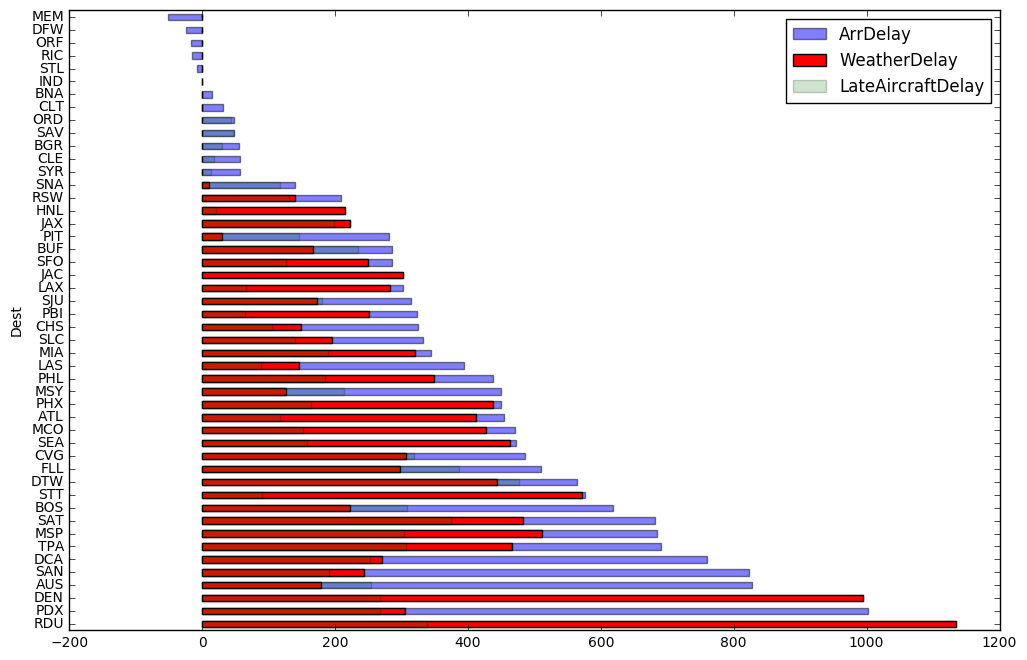

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
x.groupby('Dest', as_index=False).max().sort_values('ArrDelay', ascending=False).plot(x='Dest', y='ArrDelay', kind='barh', ax=ax, alpha=0.5);
x.groupby('Dest', as_index=False).max().sort_values('ArrDelay', ascending=False).plot(x='Dest', y='WeatherDelay', kind='barh', ax=ax, colors='r');
x.groupby('Dest', as_index=False).max().sort_values('ArrDelay', ascending=False).plot(x='Dest', y='LateAircraftDelay', kind='barh', ax=ax, colors='g', alpha=0.2);

In [14]:
df[df['PerformanceID'] == '2010_01_011979010311348712478N345NB'].sort_values('Obsv_Type').head()

,PerformanceID,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,...,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,IATA,StationID,StationID,Date,Obsv_Type,Obsv_Value
515,2010_01_011979010311348712478N345NB,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N345NB,2281,JFK,New York,New York,MSP,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,AWND,24
461,2010_01_011979010311348712478N345NB,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N345NB,2281,JFK,New York,New York,MSP,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,FMTM,2359
407,2010_01_011979010311348712478N345NB,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N345NB,2281,JFK,New York,New York,MSP,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,PGTM,2355
677,2010_01_011979010311348712478N345NB,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N345NB,2281,JFK,New York,New York,MSP,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,PRCP,10
623,2010_01_011979010311348712478N345NB,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N345NB,2281,JFK,New York,New York,MSP,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,SNOW,0


In [15]:
df_exp = df.drop(['Obsv_Type', 'Obsv_Value'], axis=1).sort_values('PerformanceID').drop_duplicates(['PerformanceID']).set_index('PerformanceID').join(df.pivot(index='PerformanceID', columns='Obsv_Type', values='Obsv_Value'))

In [16]:
df_exp.describe()

/home/chrisgiler/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,FlightNum,DepDelay,DepDelayMinutes,DepDel15,ArrDelay,ArrDelayMinutes,ArrDel15,TaxiOut,TaxiIn,CRSElapsedTime,...,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
count,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,...,230.0,16377.0,5579.0,85.0,25539.0,59.0,4556.0,44.0,53.0,263.0
mean,1224.206278,11.365311,13.760540,0.190540,-0.437901,13.676246,0.190454,30.299243,7.663099,273.489363,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,983.933655,43.819920,42.973747,0.392728,49.138797,42.642053,0.392660,16.312083,5.953179,99.863412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,-84.000000,0.000000,0.000000,-98.000000,0.000000,0.000000,1.000000,1.000000,63.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,429.000000,-4.000000,0.000000,0.000000,-24.000000,0.000000,0.000000,20.000000,4.000000,187.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,729.000000,-1.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,26.000000,6.000000,270.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2171.000000,8.000000,8.000000,0.000000,7.000000,7.000000,0.000000,36.000000,9.000000,373.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,7379.000000,1179.000000,1179.000000,1.000000,1177.000000,1177.000000,1.000000,180.000000,167.000000,718.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
# replace na with 0 for WT** variables
import re

for col in df_exp.columns:
    match = re.fullmatch('^WT\d+$', col)
    if match:
        df_exp.loc[:, col] = df_exp.loc[:, col].fillna(0)

In [18]:
df_exp.isnull().sum(axis=0).sort_values(ascending=False)

FirstDepTime         183905
TotalAddGTime        183905
LongestAddGTime      183905
WESD                 166840
PGTM                 153123
FMTM                 152493
TAVG                  62595
WDF5                   4008
WSF5                   4008
ArrDelayMinutes           0
ArrDel15                  0
TaxiOut                   0
WheelsOff                 0
TaxiIn                    0
WheelsOn                  0
ArrTimeBlk                0
Cancelled                 0
Diverted                  0
CRSElapsedTime            0
ActualElapsedTime         0
AirTime                   0
Flights                   0
ArrDelay                  0
WT22                      0
DistanceGroup             0
ArrTime                   0
FlightDate                0
Carrier                   0
TailNum                   0
FlightNum                 0
                      ...  
WT07                      0
WT08                      0
WT09                      0
WT13                      0
WT02                

In [19]:
df_exp.describe()

/home/chrisgiler/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,FlightNum,DepDelay,DepDelayMinutes,DepDel15,ArrDelay,ArrDelayMinutes,ArrDel15,TaxiOut,TaxiIn,CRSElapsedTime,...,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
count,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,...,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000,185672.000000
mean,1224.206278,11.365311,13.760540,0.190540,-0.437901,13.676246,0.190454,30.299243,7.663099,273.489363,...,0.001239,0.088204,0.030048,0.000458,0.137549,0.000318,0.024538,0.000237,0.000285,0.001416
std,983.933655,43.819920,42.973747,0.392728,49.138797,42.642053,0.392660,16.312083,5.953179,99.863412,...,0.035174,0.283592,0.170719,0.021391,0.344427,0.017823,0.154712,0.015392,0.016893,0.037610
min,1.000000,-84.000000,0.000000,0.000000,-98.000000,0.000000,0.000000,1.000000,1.000000,63.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,429.000000,-4.000000,0.000000,0.000000,-24.000000,0.000000,0.000000,20.000000,4.000000,187.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,729.000000,-1.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,26.000000,6.000000,270.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2171.000000,8.000000,8.000000,0.000000,7.000000,7.000000,0.000000,36.000000,9.000000,373.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7379.000000,1179.000000,1179.000000,1.000000,1177.000000,1177.000000,1.000000,180.000000,167.000000,718.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
df_exp.dropna(axis=1, inplace=True)

In [21]:
x = df_exp['CRSArrTime'].iloc[20]
x.minute

20

In [22]:
df_exp = df_exp.join(pd.get_dummies(df_exp['Dest'], prefix='Dest', drop_first=True))

In [23]:
df_exp.head()

,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,DestCityName,...,Dest_SAV,Dest_SEA,Dest_SFO,Dest_SJU,Dest_SLC,Dest_SNA,Dest_STL,Dest_STT,Dest_SYR,Dest_TPA
PerformanceID,,,,,,,,,,,,,,,,,,,,,
2010_01_011979010191486912478N3748Y,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3748Y,1103,JFK,New York,New York,SLC,Salt Lake City,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2010_01_011979010311348712478N345NB,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N345NB,2281,JFK,New York,New York,MSP,Minneapolis,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010_01_011979011161289212478N705TW,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N705TW,703,JFK,New York,New York,LAX,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010_01_011979011381320412478N932DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N932DL,1811,JFK,New York,New York,MCO,Orlando,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010_01_011979011421330312478N912DE,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N912DE,87,JFK,New York,New York,MIA,Miami,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_exp['Year'] = df_exp['FlightDate'].apply(lambda x: x.year)
df_exp['ISO_Weekday'] = df_exp['FlightDate'].apply(lambda x: x.weekday())
df_exp['Day_of_Year'] = df_exp['FlightDate'].apply(lambda x: x.timetuple().tm_yday)
df_exp['ArrHour'] = df_exp['CRSArrTime'].apply(lambda x: x.hour)
df_exp['DepHour'] = df_exp['CRSDepTime'].apply(lambda x: x.hour)
df_exp.head()

,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,DestCityName,...,Dest_SNA,Dest_STL,Dest_STT,Dest_SYR,Dest_TPA,Year,ISO_Weekday,Day_of_Year,ArrHour,DepHour
PerformanceID,,,,,,,,,,,,,,,,,,,,,
2010_01_011979010191486912478N3748Y,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3748Y,1103,JFK,New York,New York,SLC,Salt Lake City,...,0.0,0.0,0.0,0.0,0.0,2010,4,1,10,6
2010_01_011979010311348712478N345NB,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N345NB,2281,JFK,New York,New York,MSP,Minneapolis,...,0.0,0.0,0.0,0.0,0.0,2010,4,1,10,8
2010_01_011979011161289212478N705TW,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N705TW,703,JFK,New York,New York,LAX,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,2010,4,1,11,8
2010_01_011979011381320412478N932DL,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N932DL,1811,JFK,New York,New York,MCO,Orlando,...,0.0,0.0,0.0,0.0,0.0,2010,4,1,11,8
2010_01_011979011421330312478N912DE,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N912DE,87,JFK,New York,New York,MIA,Miami,...,0.0,0.0,0.0,0.0,0.0,2010,4,1,11,8


In [25]:
dest_cols = []
for col in df_exp.columns:
    match = re.fullmatch('^Dest_[A-Z]+$', col)
    if match:
        dest_cols.append(col)
print(dest_cols)

['Dest_AUS', 'Dest_BGR', 'Dest_BNA', 'Dest_BOS', 'Dest_BUF', 'Dest_CHS', 'Dest_CLE', 'Dest_CLT', 'Dest_CVG', 'Dest_DCA', 'Dest_DEN', 'Dest_DFW', 'Dest_DTW', 'Dest_FLL', 'Dest_HNL', 'Dest_IND', 'Dest_JAC', 'Dest_JAX', 'Dest_LAS', 'Dest_LAX', 'Dest_MCO', 'Dest_MEM', 'Dest_MIA', 'Dest_MSP', 'Dest_MSY', 'Dest_ORD', 'Dest_ORF', 'Dest_PBI', 'Dest_PDX', 'Dest_PHL', 'Dest_PHX', 'Dest_PIT', 'Dest_RDU', 'Dest_RIC', 'Dest_RSW', 'Dest_SAN', 'Dest_SAT', 'Dest_SAV', 'Dest_SEA', 'Dest_SFO', 'Dest_SJU', 'Dest_SLC', 'Dest_SNA', 'Dest_STL', 'Dest_STT', 'Dest_SYR', 'Dest_TPA']


In [71]:
label = df_exp['ArrDel15']
feature_names = ['CRSElapsedTime', 'Flights', 'Distance', 'AWND', 'Year', 'ISO_Weekday', 
                 'Day_of_Year', 'ArrHour', 'DepHour',
                 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'WDF2', 'WSF2', 'WT01', 'WT02',
                 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT11', 'WT13',
                 'WT14', 'WT15', 'WT16', 'WT17', 'WT18', 'WT19', 'WT21', 'WT22']
# feature_names += dest_cols
features = df_exp.loc[:,feature_names]
features.head()

,CRSElapsedTime,Flights,Distance,AWND,Year,ISO_Weekday,Day_of_Year,ArrHour,DepHour,PRCP,...,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
PerformanceID,,,,,,,,,,,,,,,,,,,,,
2010_01_011979010191486912478N3748Y,344.0,1.0,1989.0,24.0,2010,4,1,10,6,10.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2010_01_011979010311348712478N345NB,209.0,1.0,1028.0,24.0,2010,4,1,10,8,10.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2010_01_011979011161289212478N705TW,395.0,1.0,2475.0,24.0,2010,4,1,11,8,10.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2010_01_011979011381320412478N932DL,197.0,1.0,944.0,24.0,2010,4,1,11,8,10.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2010_01_011979011421330312478N912DE,210.0,1.0,1090.0,24.0,2010,4,1,11,8,10.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [94]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, accuracy_score

In [95]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)

In [100]:
clf = RandomForestClassifier(n_estimators=20)
# clf = AdaBoostClassifier(base_estimator=RandomForestClassifier())
# clf = SVC()
# clf = LogisticRegression()
# clf = GaussianNB()

In [101]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [102]:
y_pred = clf.predict(X_test)

In [103]:
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Precision: 0.602652259332
Recall: 0.347789115646
Accuracy: 0.832501525978


In [104]:
print(confusion_matrix(y_test, y_pred))

[[42691  2427]
 [ 6903  3681]]


In [70]:
# Baseline
y_base = [1]*len(y_pred)
print("Precision:", precision_score(y_test, y_base))
print("Recall:", recall_score(y_test, y_base))
print("Accuracy:", accuracy_score(y_test, y_base))
print(confusion_matrix(y_test, y_base))

Precision: 0.18971576297
Recall: 1.0
Accuracy: 0.18971576297
[[    0 60179]
 [    0 14090]]
